In [2]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)



[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


All results will be saved to: d:\SKRIPSI\Code\poisoning_detection\Src\Results
CSV file not found, creating sample data...
Total samples: 230
Clean samples: 200
Poisoned samples: 30
Extracting characteristics...
Training on 200 clean samples...
Computed centroids for 5 genres
Running detection...
=== Detection Performance ===
Accuracy: 0.870
Precision: 0.000
Recall: 0.000
F1-Score: 0.000


d:\SKRIPSI\Code\poisoning_detection\poisoning_detection\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


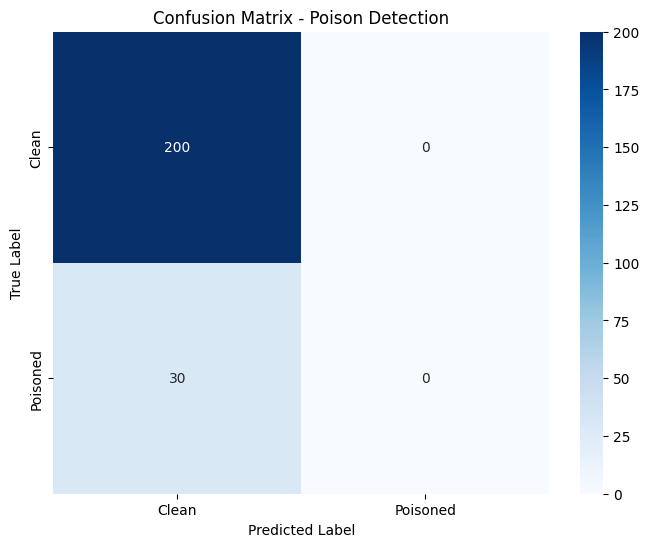

Confusion matrix saved to: Results\confusion_matrix.png


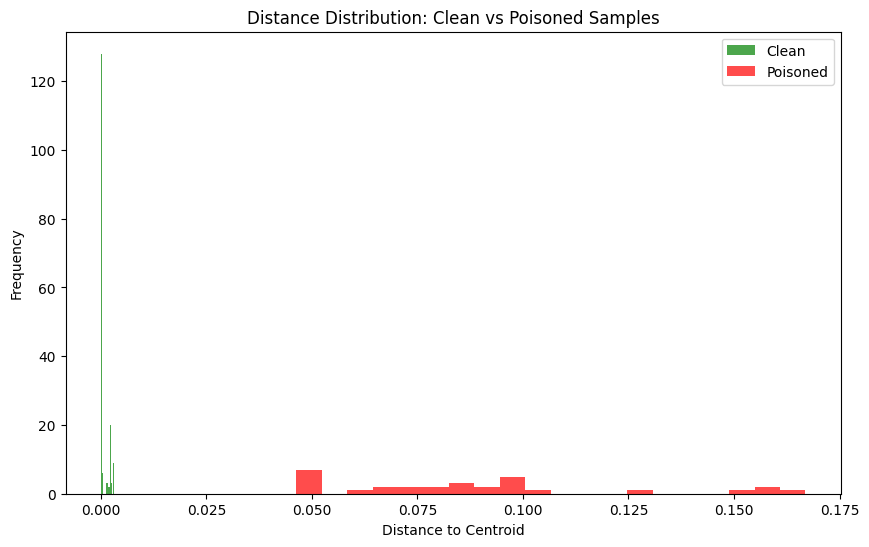

Distance distribution saved to: Results\distance_distribution.png


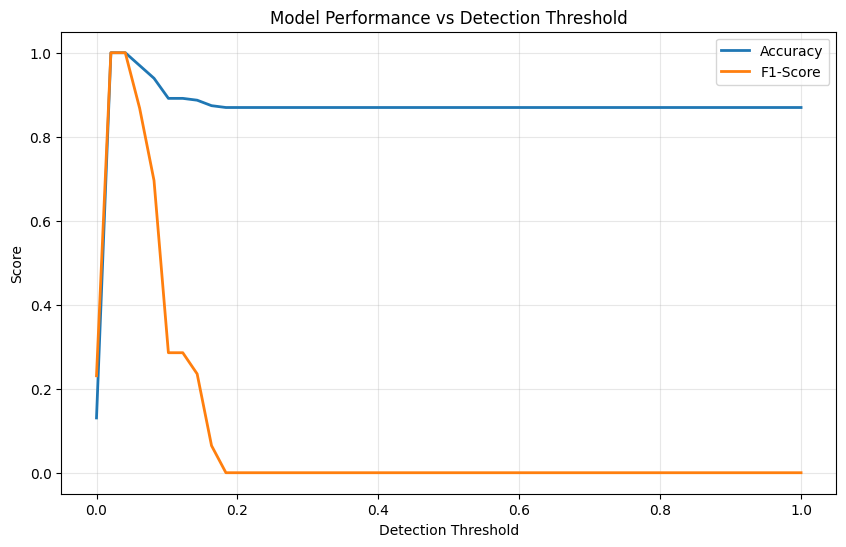

Threshold analysis saved to: Results\threshold_analysis.png

=== Distance Statistics ===
Clean samples: 200
Poisoned samples: 30
Average distance - Clean: 0.001 (±0.001)
Average distance - Poisoned: 0.087 (±0.035)
Max distance - Clean: 0.003
Max distance - Poisoned: 0.167
Results saved to: Results\detection_results.csv
Detailed report saved to: Results\detection_report.txt

=== Sample Predictions ===
✓ Movie 156... | Pred: CLEAN    | Actual: CLEAN    | Dist: 0.000
✓ Movie 106... | Pred: CLEAN    | Actual: CLEAN    | Dist: 0.002
✗ Movie 164 - buy now!... | Pred: CLEAN    | Actual: POISONED | Dist: 0.046
✓ Movie 146... | Pred: CLEAN    | Actual: CLEAN    | Dist: 0.000
✓ Movie 135... | Pred: CLEAN    | Actual: CLEAN    | Dist: 0.000

=== SUMMARY ===
All results have been saved to the 'Results' folder:
  - Detection results: Results\detection_results.csv
  - Detailed report: Results\detection_report.txt
  - Confusion matrix: Results\confusion_matrix.png
  - Distance distribution: Results\d

In [5]:
# File: evaluate_detector.py
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os

# Create Results directory if it doesn't exist
results_dir = "Results"
os.makedirs(results_dir, exist_ok=True)

# Define all necessary classes in the same file
class PoisonSimulator:
    def __init__(self):
        self.poison_keywords = ['free', 'download', 'watch now', 'click here', 'limited time', 
                               'exclusive', 'secret', 'hidden', 'special offer', 'buy now']
    
    def generate_poisoned_dataset(self, movies, poison_ratio=0.2):
        """Generate poisoned dataset by injecting malicious keywords"""
        clean_df = movies.copy()
        clean_df['is_poisoned'] = False
        clean_df['poisoned_description'] = clean_df['title']  # Using title as placeholder
        
        # Create poisoned samples
        n_poison = int(len(movies) * poison_ratio)
        poison_indices = random.sample(range(len(movies)), n_poison)
        
        poisoned_df = movies.iloc[poison_indices].copy()
        poisoned_df['is_poisoned'] = True
        
        # Add poison keywords to descriptions
        poisoned_descriptions = []
        for idx, row in poisoned_df.iterrows():
            base_desc = row['title']
            keyword = random.choice(self.poison_keywords)
            poisoned_desc = f"{base_desc} - {keyword}!"
            poisoned_descriptions.append(poisoned_desc)
        
        poisoned_df['poisoned_description'] = poisoned_descriptions
        
        return clean_df, poisoned_df

class CharacteristicVectorExtractor:
    def __init__(self, vector_size=50):
        self.vector_size = vector_size
    
    def simple_embedding(self, text):
        """Create simple text embedding based on character frequencies"""
        text = str(text).lower()
        embedding = np.zeros(self.vector_size)
        
        for i, char in enumerate(text[:self.vector_size]):
            if i < len(text):
                embedding[i] = ord(char) % 100 / 100.0  # Normalize
        
        # Fill remaining positions if text is shorter than vector_size
        if len(text) < self.vector_size:
            for i in range(len(text), self.vector_size):
                embedding[i] = (i * 13) % 100 / 100.0  # Pseudo-random fill
        
        return embedding
    
    def extract(self, description):
        """Extract characteristic vector from description"""
        embedding = self.simple_embedding(description)
        return {
            'embedding': embedding,
            'length': len(description),
            'has_special_chars': any(c in description for c in '!@#$%^&*()')
        }
    
    def batch_extract(self, descriptions, batch_size=16):
        """Extract characteristics for multiple descriptions"""
        return [self.extract(desc) for desc in descriptions]

class SimplePoisonDetector:
    def __init__(self, threshold=0.8):
        self.threshold = threshold
        self.centroids = {}
        self.is_fitted = False
    
    def compute_centroids(self, characteristics, genres):
        """Compute centroids for each genre"""
        genre_vectors = {}
        
        for char_vec, genre in zip(characteristics, genres):
            if genre not in genre_vectors:
                genre_vectors[genre] = []
            genre_vectors[genre].append(char_vec['embedding'])
        
        # Compute centroid for each genre
        for genre, vectors in genre_vectors.items():
            self.centroids[genre] = np.mean(vectors, axis=0)
        
        self.is_fitted = True
        print(f"Computed centroids for {len(self.centroids)} genres")
    
    def detect_poison(self, characteristics, genres):
        """Detect poisoned items based on distance to centroid"""
        if not self.is_fitted:
            raise ValueError("Detector not fitted. Call compute_centroids first.")
        
        predictions = []
        distances = []
        
        for char_vec, genre in zip(characteristics, genres):
            if genre not in self.centroids:
                # Unknown genre, mark as suspicious
                predictions.append(True)
                distances.append(1.0)
                continue
            
            embedding = char_vec['embedding']
            centroid = self.centroids[genre]
            
            # Compute cosine distance
            similarity = cosine_similarity([embedding], [centroid])[0][0]
            distance = 1 - similarity
            
            distances.append(distance)
            predictions.append(distance > self.threshold)
        
        return predictions, distances

def evaluate_detection(true_labels, predictions, distances):
    """Comprehensive evaluation of poison detection"""
    
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    accuracy = np.mean([p == tl for p, tl in zip(predictions, true_labels)])
    
    print("=== Detection Performance ===")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1-Score: {f1:.3f}")
    
    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Clean', 'Poisoned'], 
                yticklabels=['Clean', 'Poisoned'])
    plt.title('Confusion Matrix - Poison Detection')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    confusion_matrix_path = os.path.join(results_dir, 'confusion_matrix.png')
    plt.savefig(confusion_matrix_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Confusion matrix saved to: {confusion_matrix_path}")
    
    # Plot distance distribution
    plt.figure(figsize=(10, 6))
    clean_distances = [d for d, tl in zip(distances, true_labels) if not tl]
    poison_distances = [d for d, tl in zip(distances, true_labels) if tl]
    
    plt.hist(clean_distances, alpha=0.7, label='Clean', bins=20, color='green')
    plt.hist(poison_distances, alpha=0.7, label='Poisoned', bins=20, color='red')
    plt.xlabel('Distance to Centroid')
    plt.ylabel('Frequency')
    plt.title('Distance Distribution: Clean vs Poisoned Samples')
    plt.legend()
    distance_dist_path = os.path.join(results_dir, 'distance_distribution.png')
    plt.savefig(distance_dist_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Distance distribution saved to: {distance_dist_path}")
    
    # Plot ROC-like curve (threshold sensitivity)
    thresholds = np.linspace(0, 1, 50)
    accuracies = []
    f1_scores = []
    
    for threshold in thresholds:
        threshold_predictions = [d > threshold for d in distances]
        acc = np.mean([p == tl for p, tl in zip(threshold_predictions, true_labels)])
        try:
            f1_val = f1_score(true_labels, threshold_predictions)
        except:
            f1_val = 0
        accuracies.append(acc)
        f1_scores.append(f1_val)
    
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, accuracies, label='Accuracy', linewidth=2)
    plt.plot(thresholds, f1_scores, label='F1-Score', linewidth=2)
    plt.xlabel('Detection Threshold')
    plt.ylabel('Score')
    plt.title('Model Performance vs Detection Threshold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    threshold_path = os.path.join(results_dir, 'threshold_analysis.png')
    plt.savefig(threshold_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Threshold analysis saved to: {threshold_path}")
    
    # Print detailed statistics
    print("\n=== Distance Statistics ===")
    print(f"Clean samples: {len(clean_distances)}")
    print(f"Poisoned samples: {len(poison_distances)}")
    print(f"Average distance - Clean: {np.mean(clean_distances):.3f} (±{np.std(clean_distances):.3f})")
    print(f"Average distance - Poisoned: {np.mean(poison_distances):.3f} (±{np.std(poison_distances):.3f})")
    print(f"Max distance - Clean: {np.max(clean_distances):.3f}")
    print(f"Max distance - Poisoned: {np.max(poison_distances):.3f}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'n_clean': len(clean_distances),
        'n_poisoned': len(poison_distances),
        'avg_distance_clean': np.mean(clean_distances),
        'avg_distance_poisoned': np.mean(poison_distances),
        'confusion_matrix_path': confusion_matrix_path,
        'distance_dist_path': distance_dist_path,
        'threshold_path': threshold_path
    }

def save_detailed_report(results, true_labels, predictions, distances, descriptions, genres):
    """Save detailed analysis report"""
    report_path = os.path.join(results_dir, 'detection_report.txt')
    
    with open(report_path, 'w') as f:
        f.write("POISON DETECTION SYSTEM - DETAILED REPORT\n")
        f.write("=" * 50 + "\n\n")
        
        f.write("PERFORMANCE METRICS:\n")
        f.write(f"Accuracy: {results['accuracy']:.3f}\n")
        f.write(f"Precision: {results['precision']:.3f}\n")
        f.write(f"Recall: {results['recall']:.3f}\n")
        f.write(f"F1-Score: {results['f1']:.3f}\n\n")
        
        f.write("DATASET STATISTICS:\n")
        f.write(f"Total samples: {len(true_labels)}\n")
        f.write(f"Clean samples: {results['n_clean']}\n")
        f.write(f"Poisoned samples: {results['n_poisoned']}\n")
        f.write(f"Poison ratio: {results['n_poisoned']/len(true_labels):.3f}\n\n")
        
        f.write("DISTANCE ANALYSIS:\n")
        f.write(f"Avg distance - Clean: {results['avg_distance_clean']:.3f}\n")
        f.write(f"Avg distance - Poisoned: {results['avg_distance_poisoned']:.3f}\n")
        f.write(f"Distance ratio (Poisoned/Clean): {results['avg_distance_poisoned']/results['avg_distance_clean']:.3f}\n\n")
        
        f.write("FALSE POSITIVES ANALYSIS:\n")
        false_positives = [(desc, genre, dist) for desc, genre, dist, pred, true in 
                          zip(descriptions, genres, distances, predictions, true_labels) 
                          if pred and not true]
        f.write(f"Number of false positives: {len(false_positives)}\n")
        for i, (desc, genre, dist) in enumerate(false_positives[:10]):  # Show first 10
            f.write(f"  {i+1}. {desc[:50]}... | Genre: {genre} | Distance: {dist:.3f}\n")
        
        f.write("\nFALSE NEGATIVES ANALYSIS:\n")
        false_negatives = [(desc, genre, dist) for desc, genre, dist, pred, true in 
                          zip(descriptions, genres, distances, predictions, true_labels) 
                          if not pred and true]
        f.write(f"Number of false negatives: {len(false_negatives)}\n")
        for i, (desc, genre, dist) in enumerate(false_negatives[:10]):  # Show first 10
            f.write(f"  {i+1}. {desc[:50]}... | Genre: {genre} | Distance: {dist:.3f}\n")
    
    print(f"Detailed report saved to: {report_path}")
    return report_path

if __name__ == "__main__":
    print(f"All results will be saved to: {os.path.abspath(results_dir)}")
    
    # Create sample data if file doesn't exist
    try:
        movies = pd.read_csv('data/movies.csv')
        print("Loaded movies data from CSV file")
    except FileNotFoundError:
        print("CSV file not found, creating sample data...")
        # Create sample movie data with more realistic genres
        movies_data = {
            'movieId': range(1, 201),
            'title': [f'Movie {i}' for i in range(1, 201)],
            'genres': ['Action'] * 40 + ['Comedy'] * 40 + ['Drama'] * 40 + ['Horror'] * 40 + ['Sci-Fi'] * 40
        }
        movies = pd.DataFrame(movies_data)
    
    # Load and prepare data
    simulator = PoisonSimulator()
    clean_df, poisoned_df = simulator.generate_poisoned_dataset(movies, poison_ratio=0.15)
    
    # Combine datasets
    test_df = pd.concat([
        clean_df,
        poisoned_df[poisoned_df['is_poisoned'] == True]
    ]).reset_index(drop=True)
    
    print(f"Total samples: {len(test_df)}")
    print(f"Clean samples: {len(clean_df)}")
    print(f"Poisoned samples: {len(poisoned_df[poisoned_df['is_poisoned'] == True])}")
    
    # Extract features
    extractor = CharacteristicVectorExtractor()
    descriptions = test_df['poisoned_description'].tolist()
    genres = test_df['genres'].tolist()
    true_labels = test_df['is_poisoned'].tolist()
    
    print("Extracting characteristics...")
    characteristics = extractor.batch_extract(descriptions, batch_size=16)
    
    # Train and test detector
    clean_mask = [not label for label in true_labels]
    clean_chars = [c for c, mask in zip(characteristics, clean_mask) if mask]
    clean_genres = [g for g, mask in zip(genres, clean_mask) if mask]
    
    print(f"Training on {len(clean_chars)} clean samples...")
    detector = SimplePoisonDetector(threshold=0.25)
    detector.compute_centroids(clean_chars, clean_genres)
    
    print("Running detection...")
    predictions, distances = detector.detect_poison(characteristics, genres)
    
    # Evaluate
    results = evaluate_detection(true_labels, predictions, distances)
    
    # Save results to CSV
    results_df = pd.DataFrame({
        'description': descriptions,
        'genre': genres,
        'true_label': true_labels,
        'predicted_label': predictions,
        'distance': distances,
        'correct_prediction': [p == tl for p, tl in zip(predictions, true_labels)]
    })
    csv_path = os.path.join(results_dir, 'detection_results.csv')
    results_df.to_csv(csv_path, index=False)
    print(f"Results saved to: {csv_path}")
    
    # Save detailed report
    report_path = save_detailed_report(results, true_labels, predictions, distances, descriptions, genres)
    
    # Print some examples
    print("\n=== Sample Predictions ===")
    sample_indices = random.sample(range(len(predictions)), min(5, len(predictions)))
    for i in sample_indices:
        status = "POISONED" if predictions[i] else "CLEAN"
        actual = "POISONED" if true_labels[i] else "CLEAN"
        correct = "✓" if predictions[i] == true_labels[i] else "✗"
        print(f"{correct} {descriptions[i][:35]}... | Pred: {status:8} | Actual: {actual:8} | Dist: {distances[i]:.3f}")
    
    print(f"\n=== SUMMARY ===")
    print(f"All results have been saved to the 'Results' folder:")
    print(f"  - Detection results: {csv_path}")
    print(f"  - Detailed report: {report_path}")
    print(f"  - Confusion matrix: {results['confusion_matrix_path']}")
    print(f"  - Distance distribution: {results['distance_dist_path']}")
    print(f"  - Threshold analysis: {results['threshold_path']}")